In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm



# Hydro Task Dario Hug #

@Files   :   visualization.ipynb / task01.cpp / task02.cpp

@Time    :   2024/12/17 13:08:54

@Author  :   Dario B. Hug

@Contact :   dariobenjamin.hug@uzh.ch

@Code    :   https://github.com/dariohug/03_Hydro_project.git

Documentation: 

In this Exercise I used c++ and python. The heavy lifting is done in c++ to make the computation as afficient as possible, while python is very handy to plot the computated data.


## General Code ##

In [12]:
def read_csv_data(path):
    data = pd.read_csv(path)
    x = data['x'].values
    times = data.columns[1:]
    return x, times


## Task 1.1 - Advection with first order differencing ##

First order advection equation: $ \frac{\delta f}{\delta t} + v_0 \frac{\delta f}{\delta x} = 0$ 

- Define the domain $ 0 < x < 1 $, with periodic conditions (and ghost cells if necessary). Use $ N = 100 $ points to begin with.
- The advection velocity is v0 = 1. This defines the timestep by the CFL condition as for example $ \Delta t = \frac{\Delta x}{2 v_0} $. Because $ v0 > 0 $, be careful to define the gradient ∂f/∂x in a upstream way using finite difference.
- Perform the time integration with a first order explicit scheme for the spacial derivative. Start with a first order Euler time integration, but feel free to test also higher order schemes (RK2, RK4). Test different initial profiles of f. For example a step function $ f(x,t = 0) = 1 $ if $ x < 0.4 $ for 2 if $ 0.4 < x < 0.6 $, 1 if $ x > 0.6 $, or a gaussian $ f(x,t = 0) = 1 + exp( - \frac{(x-0.5)^2}{\sigma ^2}) $ with $ \sigma = 0.1 $ for instance.
- Explore the evolution over different timescales (number of times it crosses the box), under different resolutions (N = 100, 200, 500,...). Discuss the diffusion, stability and accuracy of the scheme with varying the timestep and the space resolution.

1D Advection Equation: $\frac{\partial f}{\partial t} + v_0 \frac{\partial f}{\partial x} = 0$ 

This equation describes how a value, could for example be a temperature in a medium or a object carried in a steadily moving stream, is carried along one dimension in time. $v_0$ here describes the speed of the advection, in our case we assume the speed to be positive $v_0 > 0$. 

The equation is conservative. To approximate the results we use the firs order euler and the laxWendroff Method. 

### Forward Euler ###

$ f_i^{n+1} = f_i^n - v_0 \frac{\Delta t}{\Delta x} ( f_i^n - f_{i-1}^n) $ 

where:

- $f_i^n$ is the value of $f$ at spatial position $i$ and time step $n$,
- $\Delta t$ is the time step size,
- $\Delta x$ is the spatial step size,
- $f_{i-1}^n$ represents the upwind neighbor.
  
The Forward Euler works surprinsinglz well for its simple design. Diffusion is accuring but for a simple calculations this method is really good. 

### RK2 ###

1. **Predictor Step (Euler Step):**  
   
   $ f_{i}^{*} = f_{i}^{n} - v_0 \frac{\Delta t}{\Delta x} ( f_{i}^{n} - f_{i-1}^{n} ) $

2. **Corrector Step:**  

   $ f_{i}^{n+1} = f_{i}^{n} - \frac{v_0 \Delta t}{2 \Delta x} (f_{i}^{n} - f_{i-1}^{n} + f_{i}^{*} - f_{i-1}^{*} ) $ 

where:

- $ f_i^n $ is the value of $ f $ at spatial position $ i $ and time step $ n $,
- $ f_i^* $ is the intermediate predictor value,
- $ \Delta t $ is the time step size,
- $ \Delta x $ is the spatial step size,
- $ f_{i-1}^n $ represents the upwind neighbor.

The second-order Runge-Kutta (RK2) method brought me a less significant improvement than i expected. It is visible that the diffusion happens slower than with the Forward Euler but only by a small margin. For this reason i also wanted to look at one more method. 


### Lax-Wendroff ###

$f_i^{n+1} = f_i^n - \frac{v_0 \Delta t}{2 \Delta x} ( f_{i+1}^n - f_{i-1}^n ) + \frac{(v_0 \Delta t)^2}{2 (\Delta x)^2} ( f_{i+1}^n - 2f_i^n + f_{i-1}^n)$ 

where:

- $f_{i+1}^n$ and $f_{i-1}^n$ are the upwind and downwind neighbors,
- $\Delta t$ is the time step size,
- $\Delta x$ is the spatial step size,
 
The Lax-Wendroff method is more involved as the Forward-Euler and it brings its own challenges. As visible, diffusion is less of a problem, the different timesteps are almost the same. On the other hand it must be monitored more closely on its stability. With the lower resolution this method seems to be quite unstable. 

In general it can be said, that lower Resolutions lead to faster diffusion in the data. 

In [16]:
# C++ file name
cpp_file = "task01_dario_hug.cpp"

# Define output filename
output_file_name = "01_advection_results.csv"

# Compile the C++ file
compile_command = ["g++", cpp_file, "-o", "task01"]
compile_process = subprocess.run(compile_command, capture_output=True, text=True)

methods = ["firstOrderEuler", "RK2", "laxWendroff"]
resolutions = ["100", "500"]
data_results = {}

for method in methods: 
    for resolution in resolutions:
        # Check if the compilation succeeded
        if compile_process.returncode == 0:
            print("\033[92m---Compilation succeeded---\033[0m")
            
            # Run the compiled executable
            # This is the beauty of this setup... With a python based solver this computation would take a wile
            # Starting profiles can be "step" or "gaussian"
            # Methods include "firstOrderEuler", "RK2", laxWendroff
            run_command = ["./task01", "10000", output_file_name, resolution, "gaussian", method] # command varys if you use different opperating system!
            run_process = subprocess.run(run_command, capture_output=True, text=True)
        
            # Display the output of the C++ program
            print(f"Output:     {run_process.stdout}")

            data_results[(method, resolution)] = pd.read_csv("01_advection_results.csv")

        else:
            # Display compilation errors
            print(f"\033[91mCompilation failed with errorcode:\033[0m {compile_process.stderr}")


---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv

---Compilation succeeded---
Output:     Simulations completed, results saved in: 01_advection_results.csv



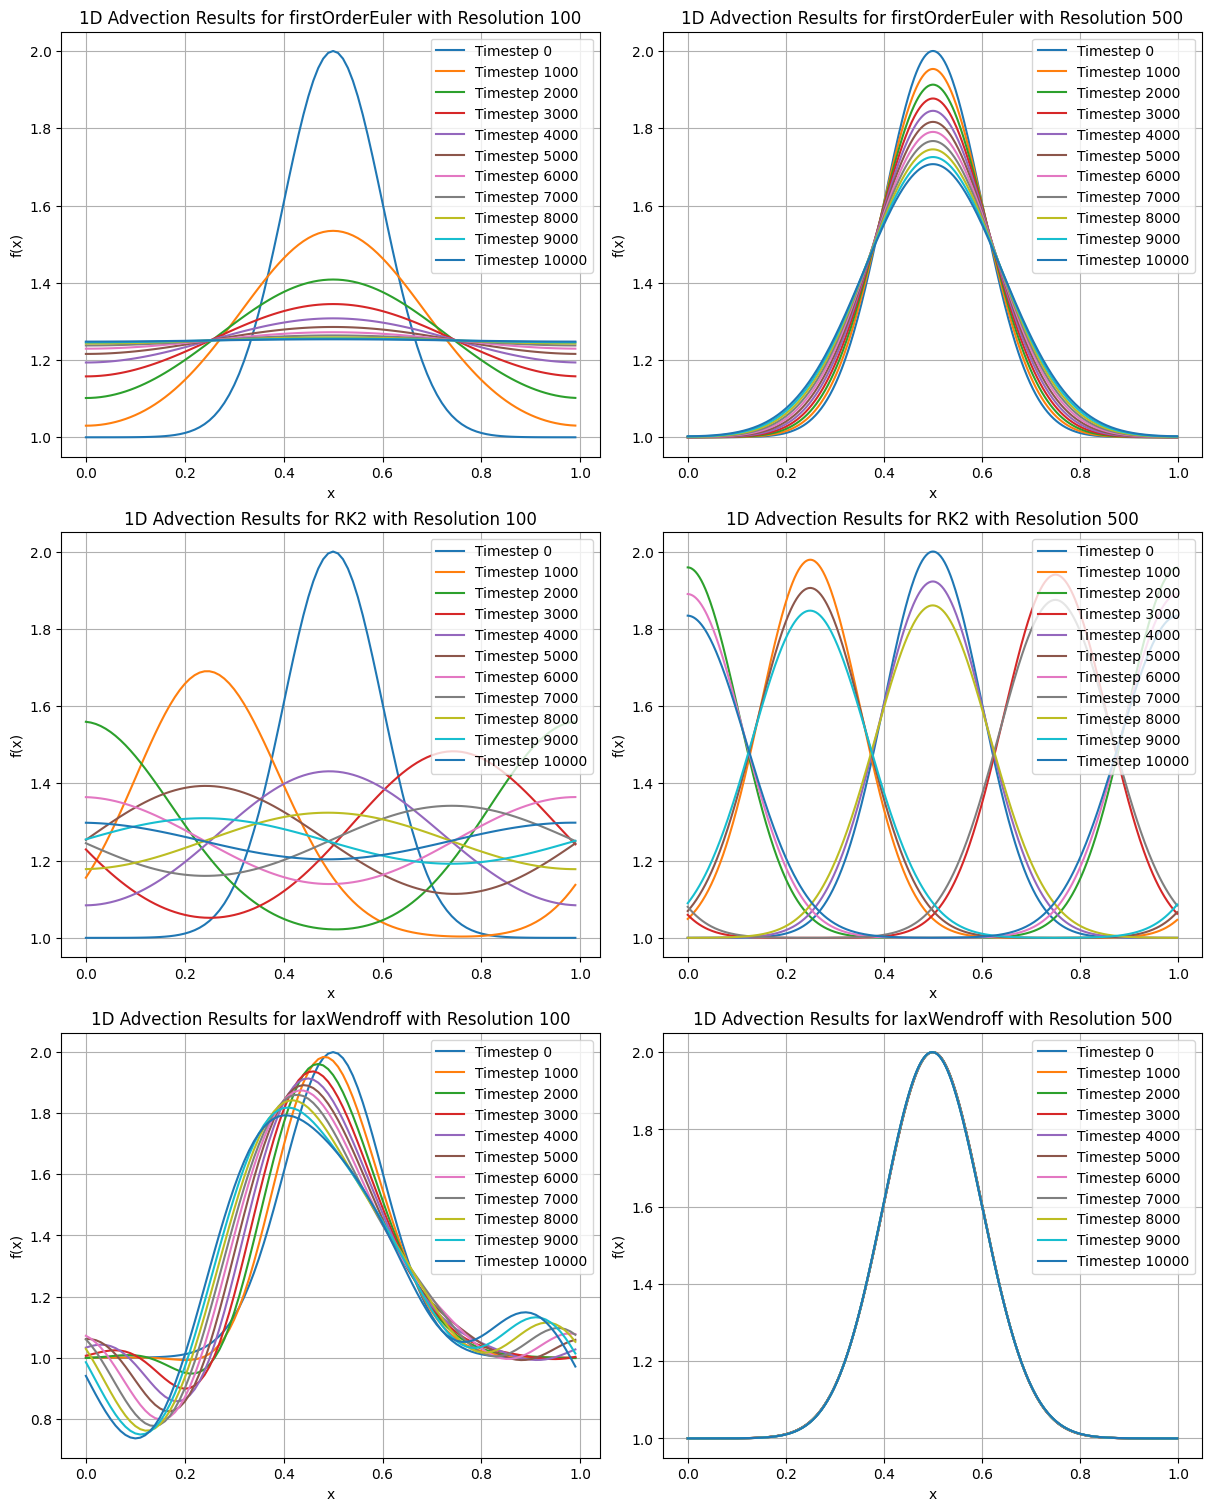

In [17]:
num_plots = len(methods) * len(resolutions)
fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout=True)
axes = axes.flatten()  # Flatten to simplify indexing

for ax, ((method, resolution), data) in zip(axes, data_results.items()):
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Adjust the plotting interval based on the number of timesteps
    num_timesteps = time_series.shape[1]
    plot_interval = max(1, num_timesteps // 10)  # Plot 10 lines

    for t in range(0, num_timesteps, plot_interval):
        ax.plot(x, time_series[:, t], label=f'Timestep {t}')

    ax.set_title(f"1D Advection Results for {method} with Resolution {resolution}")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()
    ax.legend(loc="upper right")

# Hide any unused subplots if the number of plots isn't even
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.show()

## Task 1.2: Advection with second order finite volume (MUSCL)

Same profiles and set-up as Step 1.
- Use the 2nd order MUSCL scheme: $ f(x,t + \Delta t) = f(x,t) −v0[fR(x + \Delta x/2,t + \Delta t/2) −fR(x − \Delta x/2,t+\Delta t/2)]\Delta t/\Delta x$, where fR is the solution of the Riemann problem at the cell interface. To estimate $ f(x± \Delta x/2,t+ \Delta t/2)$ , reconstruct $ f(x,t)$ on each cell by a linear function. The slope is given by a slope limiter (Minmod, Van Leer). Then move this linear function to the right $ (v0 > 0)$ by a distance $v0 \Delta t/2$. The result provides estimates of the states at $fR(x+ \Delta x/2,t+ \Delta t/2)$ and $fR(x − \Delta x/2,t + \Delta t/2)$.
- At each cell interface one has two estimates of f at $t + \Delta t/2$: one from the cell on the left, one from the cell on the right. The solution of the flux, fR, is the value from the cell upstream ( left if $v0 > 0$ )
- Explore the evolution over different timescales (number of times it crosses the box), under different resolutions (N = 100, 200, 500,...). Discuss the diffusion, stability and accuracy of the scheme with varying the timestep, the space resolution, and the slope limiter. Compare with
the results in Step 1.

### Riemann Solver ###

$ f_i^{n+1} = f_i^n - \frac{\Delta t}{\Delta x} * (F_{i+1/2} - F_{i-1/2}) $ 

$ F_{i + \frac{1}{2}} = f_i^n + \frac{|v_0|}{2} * \phi(r) * (f_{i+1}^n - f_{i}^n) $ 

$ F_{i - \frac{1}{2}} = f_{i-1}^n + \frac{|v_0|}{2} * \phi(r) * (f_{i}^n - f_{i-1}^n) $ 


### Van Leer slope limiter: ###

$ \phi(r) = \frac{r + |r|}{1 + |r|} $ 

where:

$ r = \frac{f_i - f_{i+1}}{f_{i-1} - f_{i} + \epsilon} $ 

The Slope ratio measure the relative change in the function across neigboring cells. It does so by looking at the relativ difference in upwind and downwind directions. 

### MinMod Slope Limiter: ###

$ \phi(r) = max(0, min(2r, min(\frac{1 + 2r}{3}, 2))) $ 

The slope limiter is needed since otherwise suspicious ascilations can arrive. These oscilations are called Gibbs Phenomena and lead to instability. The slopelimiter is a function of the slope and ensures that slope values do not rise or fall infinitly. 

In this task we Advection Problem using the fluxes at the boundry of each cell. These fluxes are calculated using the Riemann solver shown above. In my experience, this way of computation relies on a bigger "gridsize" to remain stable, in my case im calculating and plotting the results for one with 200 cells and one with 500 cells. This way the computation seems to be relatively stable and experiences only small amounts of diffusion. 


In [28]:
# C++ file name
cpp_file = "task01_02_dario_hug.cpp"

# Define output filename
output_file_name = "01_02_advection_second_order_results.csv"

# Compile the C++ file
compile_command = ["g++", cpp_file, "-o", "task01_02"]
compile_process = subprocess.run(compile_command, capture_output=True, text=True)

resolutions = ["200", "500"]
time_scales = ["5000", "20000"]
starting_profiles = ["step"]
slope_limiters = ["vanleer", "minmod"]
data_results = {}

i = 1
for starting_profil in starting_profiles:
    for slope_limiter in slope_limiters:
        for time in time_scales:
            for resolution in resolutions:
                # Check if the compilation succeeded
                if compile_process.returncode == 0:
                    print(f"\033[92m---Compilation succeeded---\033[0m {i}/{len(resolutions) * len(time_scales) * len(starting_profiles) * len(slope_limiters)}")
                    
                    # Run the compiled executable
                    # This is the beauty of this setup... With a python based solver this computation would take a wile

                    run_command = ["./task01_02", time, output_file_name, resolution, starting_profil, slope_limiter] # command varys if you use different opperating system!
                    run_process = subprocess.run(run_command, capture_output=True, text=True)
                
                    # Display the output of the C++ program
                    print(f"Output: {run_process.stdout}, errors : [{run_process.stderr}]")

                    data_results[(starting_profil, slope_limiter, time, resolution)] = pd.read_csv(output_file_name)
                else:
                    # Display compilation errors
                    print(f"\033[91mCompilation failed with errorcode:\033[0m {compile_process.stderr}")
                i += 1


---Compilation succeeded--- 0/8
Output: step
Simulations completed, results saved in: 01_02_advection_second_order_results.csv
, errors : []
---Compilation succeeded--- 1/8
Output: step
Simulations completed, results saved in: 01_02_advection_second_order_results.csv
, errors : []
---Compilation succeeded--- 2/8
Output: step
Simulations completed, results saved in: 01_02_advection_second_order_results.csv
, errors : []
---Compilation succeeded--- 3/8
Output: step
Simulations completed, results saved in: 01_02_advection_second_order_results.csv
, errors : []
---Compilation succeeded--- 4/8
Output: step
Simulations completed, results saved in: 01_02_advection_second_order_results.csv
, errors : []
---Compilation succeeded--- 5/8
Output: step
Simulations completed, results saved in: 01_02_advection_second_order_results.csv
, errors : []
---Compilation succeeded--- 6/8
Output: step
Simulations completed, results saved in: 01_02_advection_second_order_results.csv
, errors : []
---Compilatio

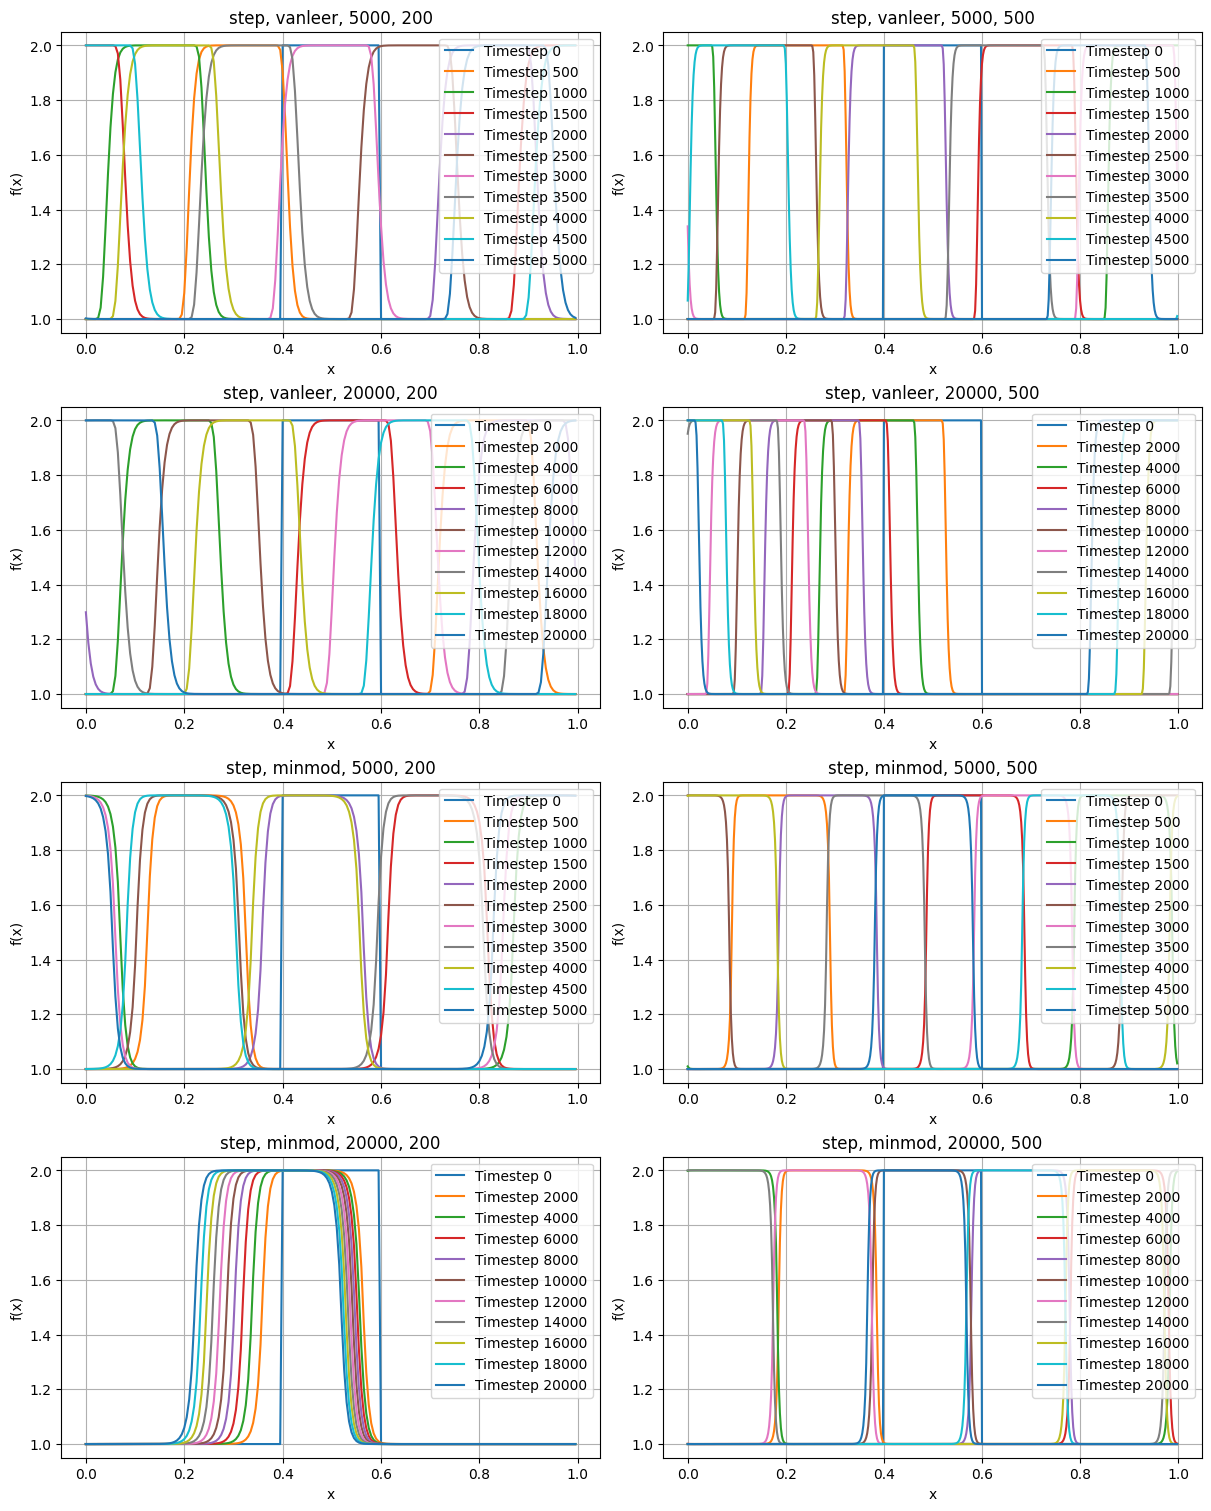

In [29]:
num_plots = len(methods) * len(resolutions) * len(starting_profiles) * len(slope_limiter)
fig, axes = plt.subplots(4, 2, figsize=(12, 15), constrained_layout=True)
axes = axes.flatten()  # Flatten to simplify indexing

for ax, ((starting_profil, slope_limiter, time, resolution), data) in zip(axes, data_results.items()):
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Adjust the plotting interval based on the number of timesteps
    num_timesteps = time_series.shape[1]
    plot_interval = num_timesteps // 10  # Plot 10 lines

    for t in range(0, num_timesteps, plot_interval):
        ax.plot(x, time_series[:, t], label=f'Timestep {t}')

    ax.set_title(f"{starting_profil}, {slope_limiter}, {time}, {resolution}")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()
    ax.legend(loc="upper right")

plt.show()

KeyboardInterrupt: 

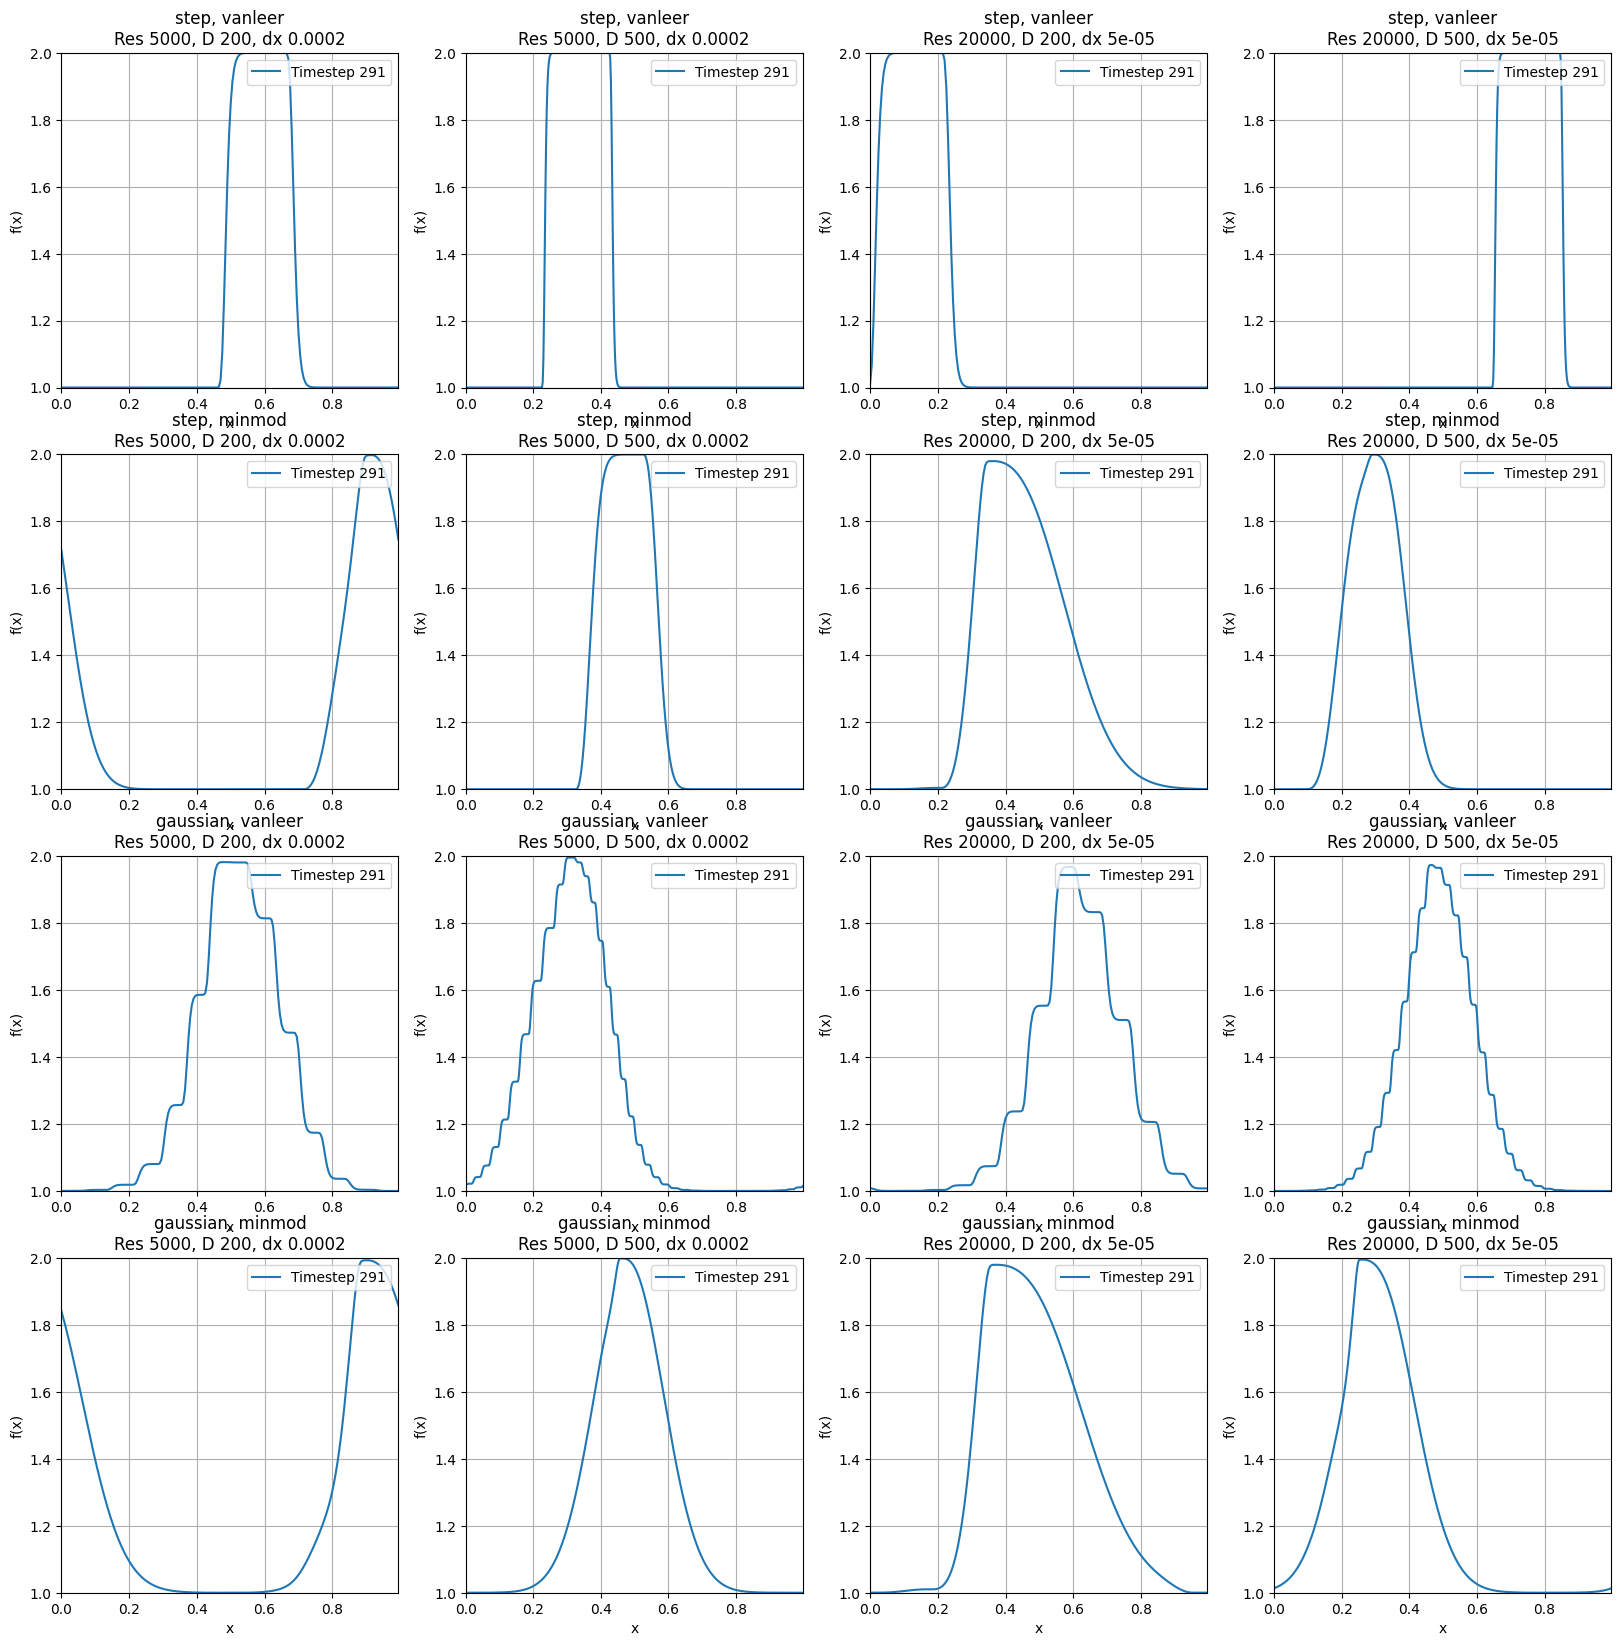

In [20]:
# https://www.geeksforgeeks.org/using-matplotlib-for-animations/

# Set up the figure
num_plots = len(data_results)
num_columns = 4
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
axes = axes.flatten()  # Flatten for easier iteration

# Parameters for frame limiting
MAX_FRAMES = 300

# Store line objects for animation
plot_lines = []
valid_axes = []

# Initialize plots
for ax, ((starting_condition, method, resolution, diffusion_coefficient), data) in zip(axes, data_results.items()):
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Check for NaN/Inf or if any value exceeds 5
    if np.any(np.isnan(time_series)) or np.any(np.isinf(time_series)) or np.any(time_series > 5):
        ax.set_title("Invalid data")
        ax.axis('off')
        continue

    # Subsample time_series to reduce frames
    num_timesteps = time_series.shape[1]
    subsample_step = max(1, num_timesteps // MAX_FRAMES)  # Calculate step size to limit frames
    time_series = time_series[:, ::subsample_step]
    num_frames = time_series.shape[1]  # Adjust frame count after subsampling

    # Initialize an empty plot for animation
    line, = ax.plot(x, np.zeros_like(x), label="Timestep 0")

    # Configure the axis
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(time_series.min(), time_series.max())
    ax.set_title(f"{starting_condition}, {method}\nRes {resolution}, D {diffusion_coefficient}, dx {1 / int(resolution)}")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()
    ax.legend(loc="upper right")

    # Store the plot line, time series, and frame count
    plot_lines.append((line, time_series, num_frames))
    valid_axes.append(ax)

# Turn off unused axes
for ax in axes[num_plots:]:
    ax.axis('off')

# Update function for animation
def update(frame):
    for (line, time_series, _), ax in zip(plot_lines, valid_axes):
        if frame < time_series.shape[1]:  # Safety to ensure frame is valid
            line.set_ydata(time_series[:, frame])  # Update y data
            line.set_label(f"Timestep {frame}")  # Update legend dynamically
            ax.legend(loc="upper right")
    return [line for line, _, _ in plot_lines]

# Determine the global number of frames for the animation
num_frames = min(MAX_FRAMES, max(frames for _, _, frames in plot_lines))

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=200, blit=True)

# Save or display the animation
ani.save("animation_task_1.2.webm", writer="ffmpeg", fps=10, codec="vp9")

## Task 2.0 The 1D Diffusion Equation ##

The goal is to solve the 1D diffusion equation 

$ \frac{\partial f}{\partial t} = D\frac{\partial^2 f}{\partial x²} $ 

where $D$ is constant and uniform. Use the same set-ups and initial profiles as before.
- Discretize the second derivative with finite differences $ \frac{\partial^2 f}{\partial x²} = \frac{f_{i+1} - 2 f_i + f_{i-1}}{\Delta x²} $. Integrate in time
with first oder Euler or second order RK. Test different values of D: from $10^{−3} $ to $1$. Test different time steps: a typical value is $\Delta t = \frac{\Delta x^2}{2D} $. Change the resolution $N$ as well.
- Compare with the numerical diffusion you obtain in the first order advection setups. Can you estimate the equivalent diffusion coefficient D for a couple of different values for resolution and timestep. 
- In the lecture you have seen that the equivalent diffusion coefficient should be $ D = \frac{v \Delta x}{2} $. This is true only if in the advection scheme, your time integration technique is at least second order (RK2 for example). If you use Euler, as in the simple first order advection scheme, then this is not true anymore and you would have $D = \frac{v \Delta x}{2} ·(1 − \frac{v \Delta t}{\Delta x}) $. Can you explain why?

With this task i started pushing my computer a bit more. Computation time was a big struggle since for every change i made, the program took 3-4 minutes to run again. This makes random tinkering even more ineffficient and really forces one to think about the changes to make in the code. 
I had to figure out which inputs produce instable results. Most errors came from to small Diffusion coefficients. Since the timestep is defined as:

$ \Delta t = \frac{\Delta x^2}{2 D} $ 

small Diffusion Coefficients (close to 0.001) lead to really big timesteps, and therefore to instabilty.
I finally got the thing relatively stable with Diffusion Coefficient values > 0.05 and a $ \Delta t = \frac{\Delta x^2}{8 * Diffusion Coefficient} $. With these values I lowered the total number of timesteps a bit, since otherwise the calculations diffused to quickly, to plot anything useful. 

These where the first result of which i also created an animation. The animation shows beautifully how large differences are smothed out quickly while the speed of the diffusion decline the smaller the differences get. 

In [54]:
# C++ file name
cpp_file = "task02_dario_hug.cpp"

# Define output filename
output_file_name = "02_diffusion_results.csv"

# Compile the C++ file
compile_command = ["g++", cpp_file, "-o", "task_02"]
compile_process = subprocess.run(compile_command, capture_output=True, text=True)

starting_conditions = ["step", "gaussian"]
methods = ["RK2"]
resolutions = ["100", "200"]
diffusion_coefficients = ["1"]
data_results = {}

i = 1
for starting_condition in starting_conditions: 
    for method in methods: 
        # if method == "RK2": resolutions = ["1", "2"]
        # if method == "firstOrderEuler": resolutions = ["100", "200"]
        for resolution in resolutions:
            for diffusion_coefficient in diffusion_coefficients:
                # Check if the compilation succeeded
                if compile_process.returncode == 0:
                    print(f"\033[92m---Compilation succeeded---\033[0m {i}/{len(starting_conditions) * len(methods) * len(resolutions) * len(diffusion_coefficients)}")
                    
                    # Run the compiled executable
                    # This is the beauty of this setup... With a python based solver this computation would take a wile
                    run_command = ["./task_02", output_file_name, starting_condition, method, resolution, diffusion_coefficient] # command varys if you use different opperating system!
                    run_process = subprocess.run(run_command, capture_output=True, text=True)
                
                    # Display the output of the C++ program
                    print(f"Output: {run_process.stdout} Errors : [{run_process.stderr}]")

                    data_results[(starting_condition, method, resolution, diffusion_coefficient)] = pd.read_csv(output_file_name)
                else:
                    # Display compilation errors
                    print(f"\033[91mCompilation failed with errorcode:\033[0m {compile_process.stderr}")

                i += 1


---Compilation succeeded--- 1/4
Output: Simulations completed, results saved in: 02_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 2/4
Output: Simulations completed, results saved in: 02_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 3/4
Output: Simulations completed, results saved in: 02_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 4/4
Output: Simulations completed, results saved in: 02_diffusion_results.csv
 Errors : []


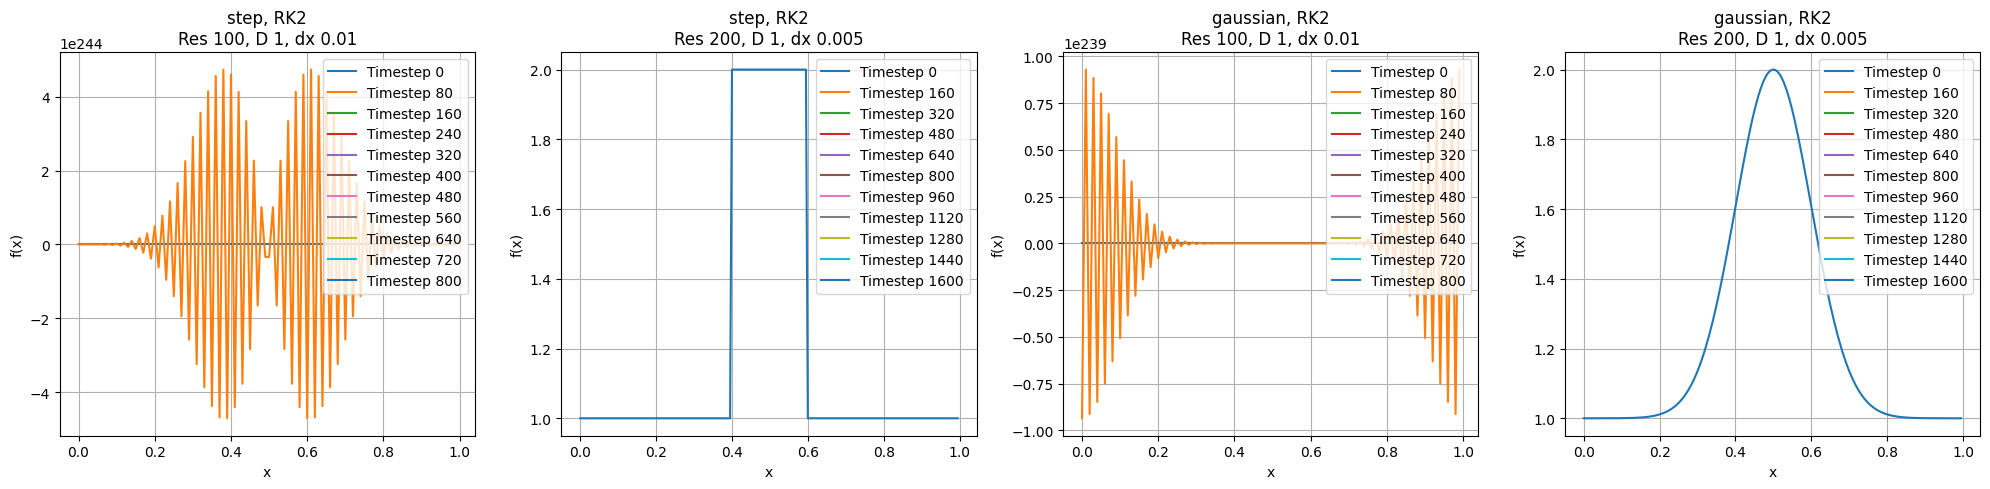

In [55]:
# Determine the number of rows needed for 4 columns
num_plots = len(data_results)
num_columns = 4
num_rows = (num_plots + num_columns - 1) // num_columns  # Ceiling division

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
axes = axes.flatten()  # Flatten axes for easier iteration

for ax, ((starting_condition, method, resolution, diffusion_coefficient), data) in zip(axes, data_results.items()):
    # Extract x values and time series data
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Determine the number of timesteps and adjust the plot interval
    num_timesteps = time_series.shape[1]
    plot_interval = max(1, num_timesteps // 10)

    # Plot results for selected timesteps
    for t in range(0, num_timesteps, plot_interval):
        ax.plot(x, time_series[:, t], label=f"Timestep {t}")

    # Customize the plot with condition-specific title and labels
    ax.set_title(f"{starting_condition}, {method}\nRes {resolution}, D {diffusion_coefficient}, dx {1 / int(resolution)}")
    ax.set_xlabel("x")
    ax.set_ylabel(f"f(x)")
    ax.grid()
    ax.legend(loc="upper right")

# Turn off any unused axes
for ax in axes[num_plots:]:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


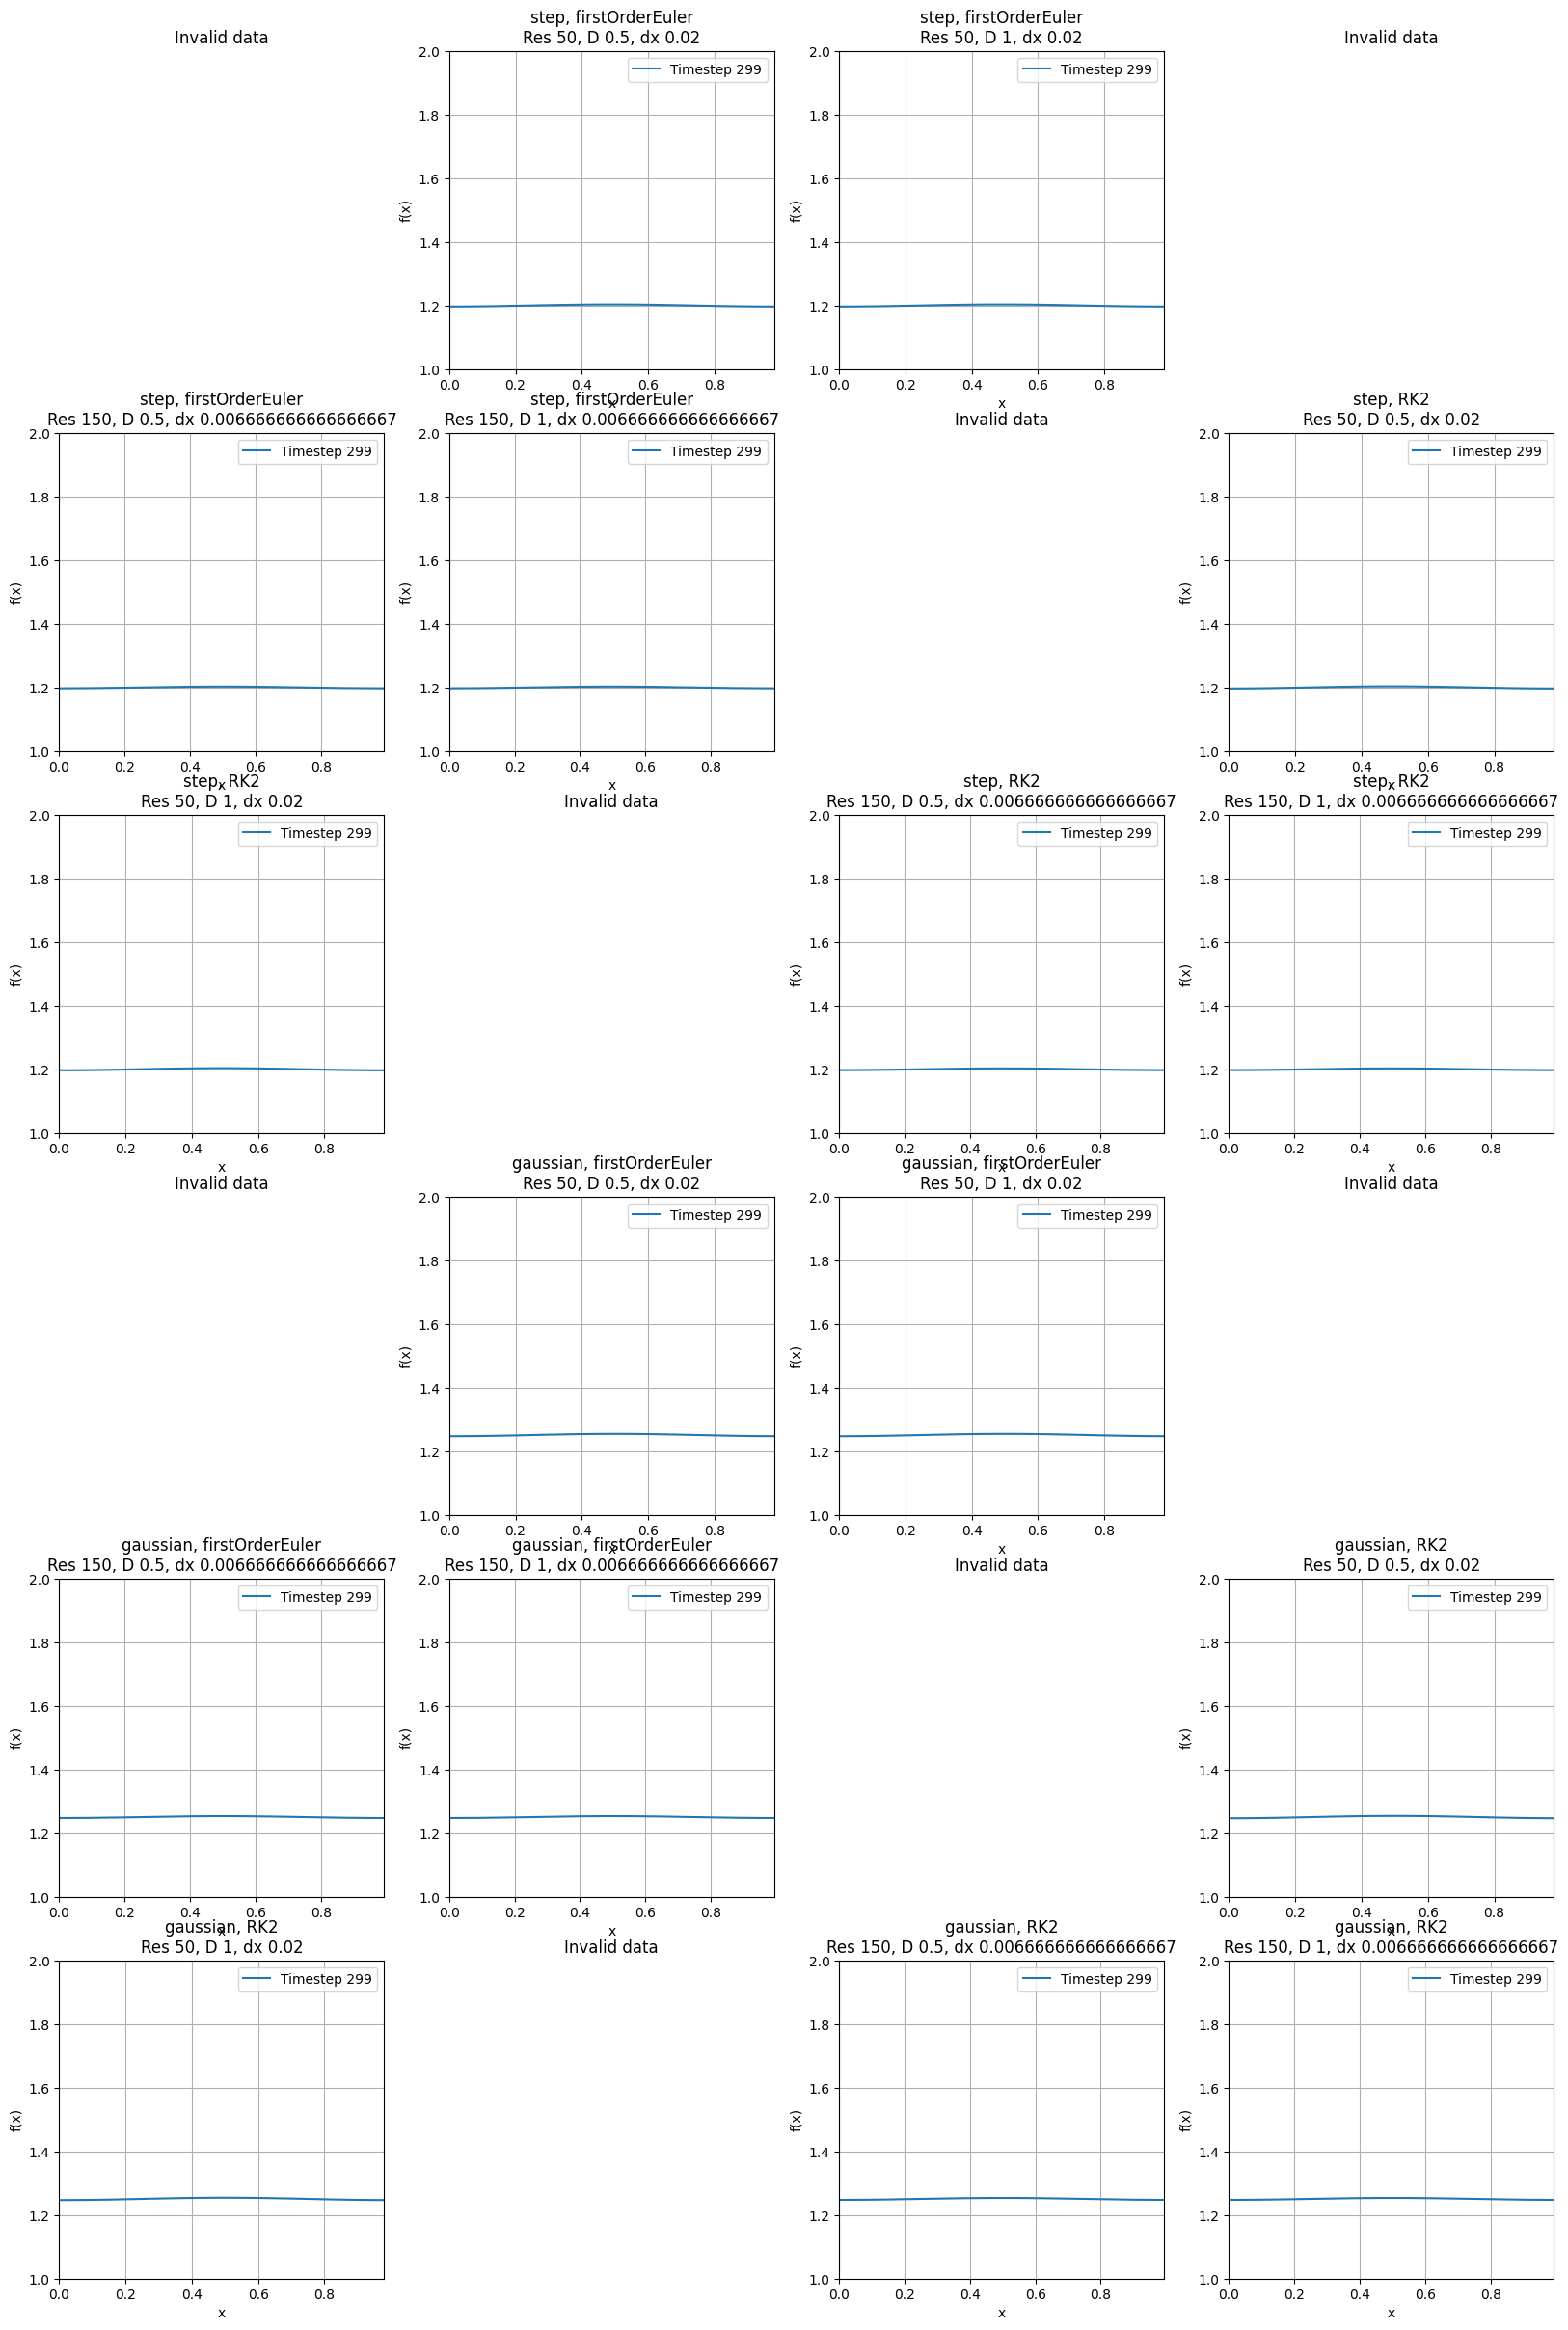

In [32]:
# https://www.geeksforgeeks.org/using-matplotlib-for-animations/

# Set up the figure
num_plots = len(data_results)
num_columns = 4
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
axes = axes.flatten()  # Flatten for easier iteration

# Parameters for frame limiting
MAX_FRAMES = 300

# Store line objects for animation
plot_lines = []
valid_axes = []

# Initialize plots
for ax, ((starting_condition, method, resolution, diffusion_coefficient), data) in zip(axes, data_results.items()):
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Check for NaN/Inf or if any value exceeds 5
    if np.any(np.isnan(time_series)) or np.any(np.isinf(time_series)) or np.any(time_series > 5):
        ax.set_title("Invalid data")
        ax.axis('off')
        continue

    # Subsample time_series to reduce frames
    num_timesteps = time_series.shape[1]
    subsample_step = max(1, num_timesteps // MAX_FRAMES)  # Calculate step size to limit frames
    time_series = time_series[:, ::subsample_step]
    num_frames = time_series.shape[1]  # Adjust frame count after subsampling

    # Initialize an empty plot for animation
    line, = ax.plot(x, np.zeros_like(x), label="Timestep 0")

    # Configure the axis
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(time_series.min(), time_series.max())
    ax.set_title(f"{starting_condition}, {method}\nRes {resolution}, D {diffusion_coefficient}, dx {1 / int(resolution)}")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()
    ax.legend(loc="upper right")

    # Store the plot line, time series, and frame count
    plot_lines.append((line, time_series, num_frames))
    valid_axes.append(ax)

# Turn off unused axes
for ax in axes[num_plots:]:
    ax.axis('off')

# Update function for animation
def update(frame):
    for (line, time_series, _), ax in zip(plot_lines, valid_axes):
        if frame < time_series.shape[1]:  # Safety to ensure frame is valid
            line.set_ydata(time_series[:, frame])  # Update y data
            line.set_label(f"Timestep {frame}")  # Update legend dynamically
            ax.legend(loc="upper right")
    return [line for line, _, _ in plot_lines]

# Determine the global number of frames for the animation
num_frames = min(MAX_FRAMES, max(frames for _, _, frames in plot_lines))

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=200, blit=True)

# Save or display the animation
ani.save("animation_diffusion.webm", writer="ffmpeg", fps=10, codec="vp9")

## Task 3.0 The 1D Advection-Diffusion Equation ##

The goal is to solve the advection-diffusion equation 

$ \frac{\partial f}{\partial t} = -v_0 \frac{\partial f}{\partial t} + D \frac{\partial ^2 f}{\partial x^2} $ 

This is a heat conducting fluid where $ f $ represents the temperature. Use the same set-ups and profiles
as before.

- Combine the two schemes (for advection, and for diffusion) using the operator splitting technique. First, solve

$ \frac{\partial f}{\partial t} = D \frac{\partial ^2 f}{\partial x^2}$, over a duration $ \frac{\Delta t}{2} $.  Then, solve 

$ \frac{\partial f}{\partial t} = -v_0 \frac{\partial f}{\partial t} $ over a duration $ \Delta t$  implementing the MUSCL scheme again. Finally, solve again 

$ \frac{\partial f}{\partial t} = D \frac{\partial ^2 f}{\partial x^2}$, over a duration $ \frac{\Delta t}{2}$.

- Explore the effect of resolution, diffusion coefficient, timestep. How do you estimate a good timestep? With the advection CFL rule or based on the diffusion coefficient?

I already encountered difficulties with predicting a good $ \Delta t $ in the last exercise. I was able to use the same formula as before and still have stable calculations. The formula being: $ \Delta t = \frac{\Delta x ^ 2 }{8 * DiffusionCoefficient} $. 
The animation also nicely shows, how the Diffusion coefficient influences the propagation of the fucntion. The Resolution has a big impact on the speed of the diffusion, with smaller grids diffusing faster. 
I also experimented with defining it the other way around: 

$ D = \frac{v_0 \Delta x}{2}(1 - \frac{v_0 \Delta t}{\Delta x}) $ 

This can be rearanged to:

$ \Delta t = \frac{-2D}{v_0²} + 1 $ 

But I had worse results this way. 

In [12]:
# C++ file name
cpp_file = "task03_dario_hug.cpp"

# Define output filename
output_file_name = "03_advection_diffusion_results.csv"

# Compile the C++ file
compile_command = ["g++", cpp_file, "-o", "task_03"]
compile_process = subprocess.run(compile_command, capture_output=True, text=True)

timesteps = ["10000", "30000"]
resolutions = ["100", "250"]
diffusion_coefficients = ["0.01", "0.1", "1"]
data_results = {}

i = 1
for nr_of_timesteps in timesteps:
    for resolution in resolutions:
        for diffusion_coefficient in diffusion_coefficients:
            # Check if the compilation succeeded
            if compile_process.returncode == 0:
                print(f"\033[92m---Compilation succeeded---\033[0m {i}/{len(timesteps) * len(resolutions) * len(diffusion_coefficients)}")
                
                # Run the compiled executable
                # This is the beauty of this setup... With a python based solver this computation would take a wile
                run_command = ["./task_03", output_file_name, nr_of_timesteps, resolution, "gaussian", diffusion_coefficient] # command varys if you use different opperating system!
                run_process = subprocess.run(run_command, capture_output=True, text=True)
            
                # Display the output of the C++ program
                print(f"Output: {run_process.stdout} Errors : [{run_process.stderr}]")

                data_results[(nr_of_timesteps, resolution, diffusion_coefficient)] = pd.read_csv(output_file_name)
            else:
                # Display compilation errors
                print(f"\033[91mCompilation failed with errorcode:\033[0m {compile_process.stderr}")

            i += 1


---Compilation succeeded--- 1/12
Output: Simulations completed, results saved in: 03_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 2/12
Output: Simulations completed, results saved in: 03_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 3/12
Output: Simulations completed, results saved in: 03_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 4/12
Output: Simulations completed, results saved in: 03_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 5/12
Output: Simulations completed, results saved in: 03_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 6/12
Output: Simulations completed, results saved in: 03_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 7/12
Output: Simulations completed, results saved in: 03_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 8/12
Output: Simulations completed, results saved in: 03_advec

12


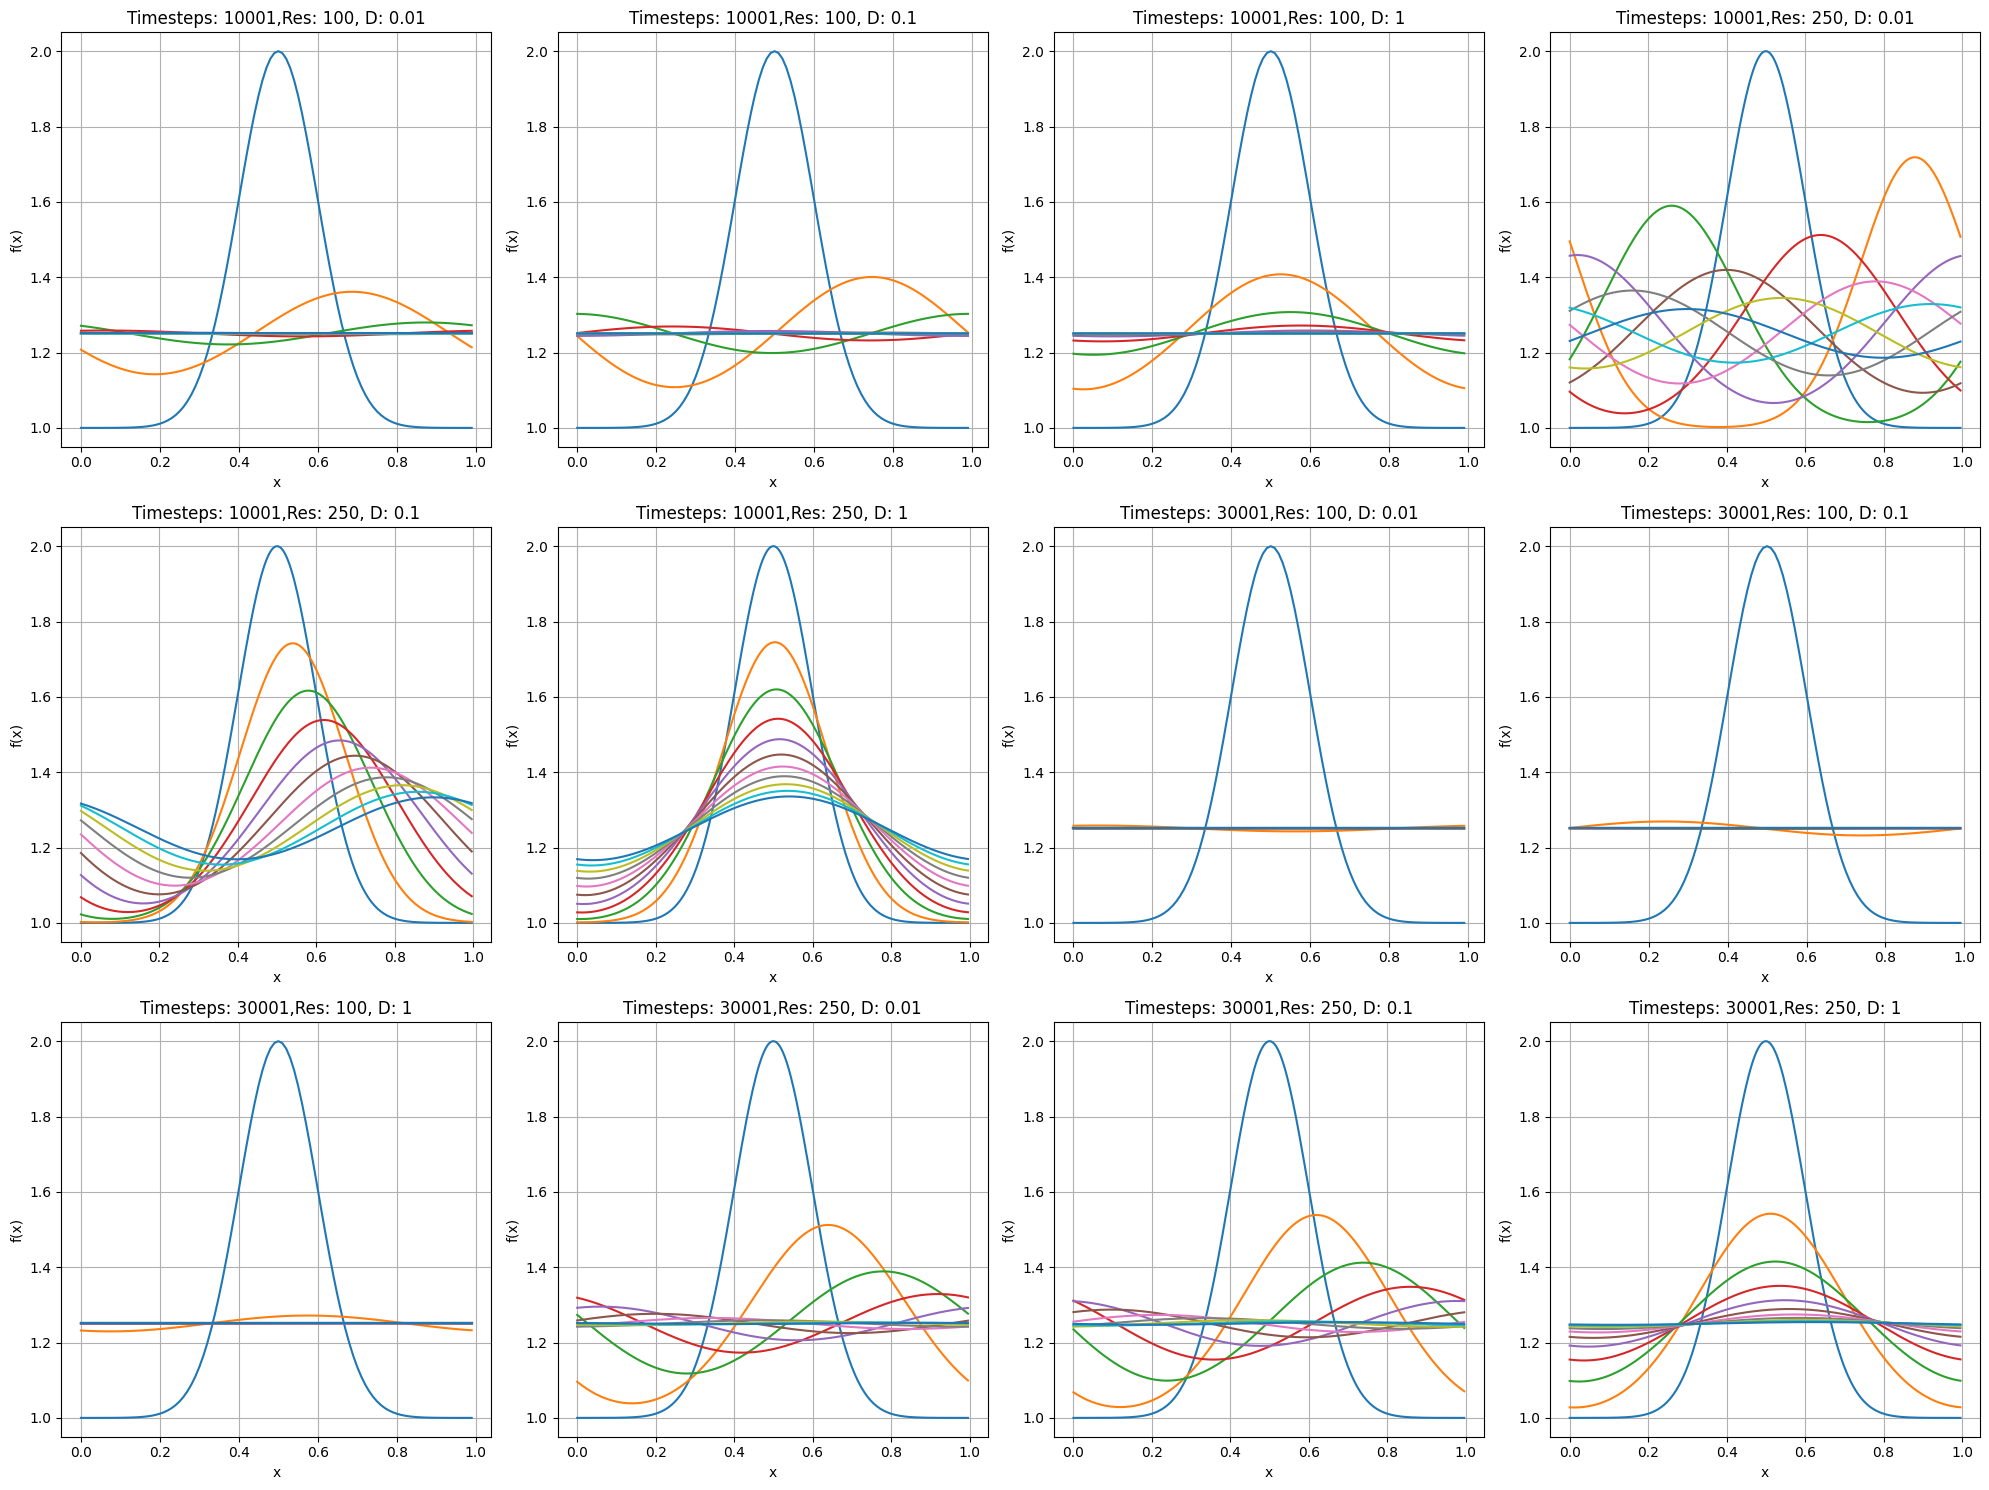

In [13]:
# Determine the number of rows needed for 4 columns
num_plots = len(data_results)
print(num_plots)
num_columns = 4
num_rows = (num_plots + num_columns - 1) // num_columns  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
axes = axes.flatten()  # Flatten axes for easier iteration

# Iterate over the data and plot
for ax, ((num_timesteps, resolution, diffusion_coefficient), data) in zip(axes, data_results.items()):
    # Extract x values and time series data
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Determine the number of timesteps and adjust the plot interval
    num_timesteps = time_series.shape[1]  # Number of timesteps from the data
    plot_interval = max(1, num_timesteps // 10)  # Plot every 10% of timesteps

    # Plot results for selected timesteps
    for t in range(0, num_timesteps, plot_interval):
        ax.plot(x, time_series[:, t], label=f"Timestep {t}")

    # Customize the plot with condition-specific title and labels
    ax.set_title(f"Timesteps: {num_timesteps},Res: {resolution}, D: {diffusion_coefficient}")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()

# Turn off any unused axes
for ax in axes[num_plots:]:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

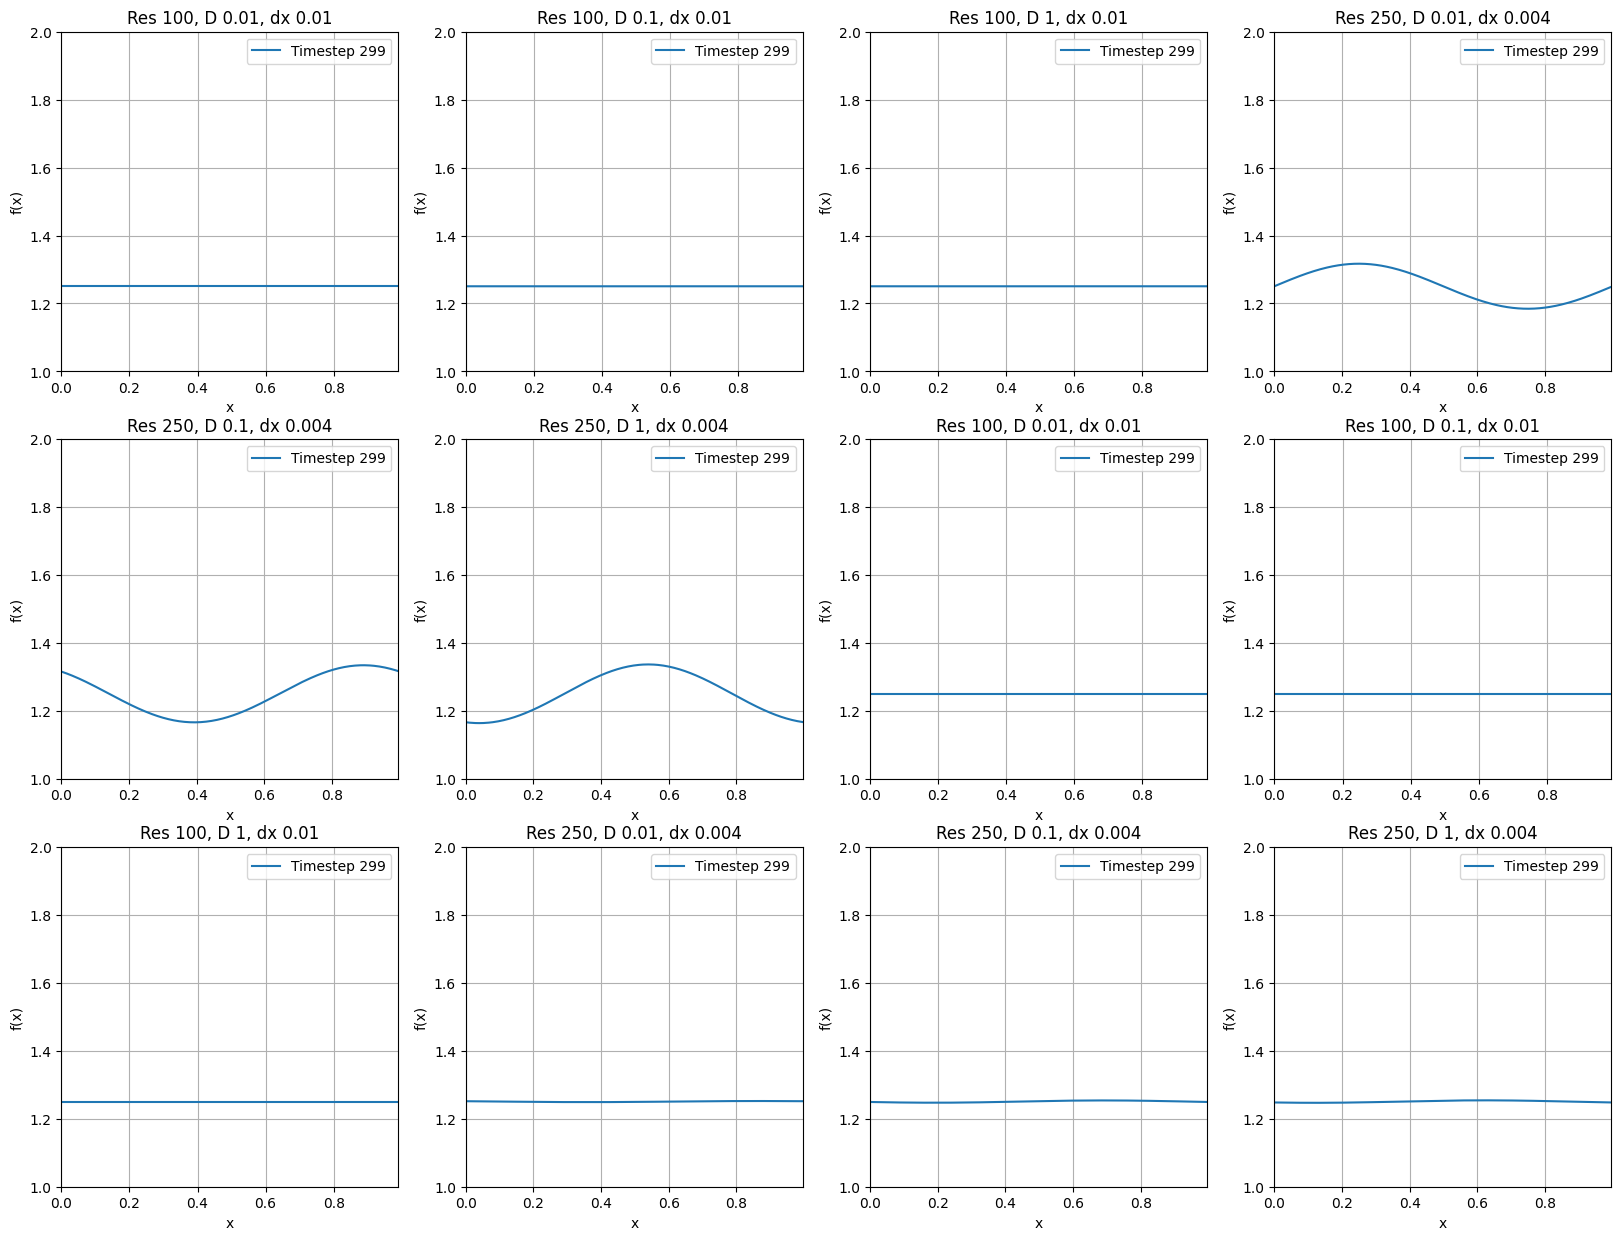

In [14]:
# https://www.geeksforgeeks.org/using-matplotlib-for-animations/

# Set up the figure
num_plots = len(data_results)
num_columns = 4
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
axes = axes.flatten()  # Flatten for easier iteration

# Parameters for frame limiting
MAX_FRAMES = 300

# Store line objects for animation
plot_lines = []
valid_axes = []

# Initialize plots
for ax, ((num_timesteps, resolution, diffusion_coefficient), data) in zip(axes, data_results.items()):
    x = data["x"].values
    time_series = data.drop(columns=["x"]).values

    # Check for NaN/Inf or if any value exceeds 5
    if np.any(np.isnan(time_series)) or np.any(np.isinf(time_series)) or np.any(time_series > 5):
        ax.set_title("Invalid data")
        ax.axis('off')
        continue

    # Subsample time_series to reduce frames
    num_timesteps = time_series.shape[1]
    subsample_step = max(1, num_timesteps // MAX_FRAMES)  # Calculate step size to limit frames
    time_series = time_series[:, ::subsample_step]
    num_frames = time_series.shape[1]  # Adjust frame count after subsampling

    # Initialize an empty plot for animation
    line, = ax.plot(x, np.zeros_like(x), label="Timestep 0")

    # Configure the axis
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(time_series.min(), time_series.max())
    ax.set_title(f"Res {resolution}, D {diffusion_coefficient}, dx {1 / int(resolution)}")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid()
    ax.legend(loc="upper right")

    # Store the plot line, time series, and frame count
    plot_lines.append((line, time_series, num_frames))
    valid_axes.append(ax)

# Turn off unused axes
for ax in axes[num_plots:]:
    ax.axis('off')

# Update function for animation
def update(frame):
    for (line, time_series, _), ax in zip(plot_lines, valid_axes):
        if frame < time_series.shape[1]:  # Safety to ensure frame is valid
            line.set_ydata(time_series[:, frame])  # Update y data
            line.set_label(f"Timestep {frame}")  # Update legend dynamically
            ax.legend(loc="upper right")
    return [line for line, _, _ in plot_lines]

# Determine the global number of frames for the animation
num_frames = min(MAX_FRAMES, max(frames for _, _, frames in plot_lines))

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=200, blit=True)

# Save or display the animation
ani.save("animation_advection_diffusion.webm", writer="ffmpeg", fps=10, codec="vp9")

### Task 4 - 2D advection ###

$ \frac{\partial f}{\partial t} = - \bf{v_0} \nabla f =  -v_x \frac{\partial f}{\partial x} - v_y \frac{\partial f}{\partial y} $ 

where $ v^2_x + v^2_y = v^2_0 $.
- Construct a 2D periodic grid in the domain 0 < x < 1 and 0 < y < 1, with Nx and Ny cells. By simplicity, assume Ny = Nx.
- To solve the 2D advection, use the operator splitting method, as described in Task 3, now using the x-advection for half a timestep, then y-advection for a full timestep, then x-advection for half a timestep. (you can also switch the direction y,x,y)
- Test different advection velocities: for example vx = 1, vy = 0, or vx = 0, vy = 1, or also $ vx = \sqrt{2}/2, vy = \sqrt{2}/2 $.
•As CFL condition, start with using $ \Delta t = \frac{1}{2} \frac{\Delta x \Delta y}{\sqrt{(\Delta y v_x)² + (\Delta y v_x)^2}} $ 

- Use 2D version of the initial conditions (step and gaussian). In addition, you can also test other initial profiles (be careful with the periodicity)
- Explore the evolution over different timescales (number of times it crosses the box), under different resolutions (Nx = Ny = 100, 200, 500,...), using different slope limiters (Minmod, van Leer, ...). Discuss the diffusion, stability and accuracy of the scheme.

In [9]:
# C++ file name
cpp_file = "task04_dario_hug.cpp"

# Define output filename
output_file_name = "04_advection_diffusion_results.csv"

# Compile the C++ file
compile_command = ["g++", cpp_file, "-o", "task_04"]
compile_process = subprocess.run(compile_command, capture_output=True, text=True)

timesteps = ["1000", "10000"]
resolutions = ["25", "100"]
slope_limiter_methods = ["minmod", "vanleer"]
data_results = {}

i = 1
for slope_limiter in slope_limiter_methods: 
    for nr_of_timesteps in timesteps:
        for resolution in resolutions:
            # Check if the compilation succeeded
            if slope_limiter == "vanleer" and (nr_of_timesteps != "1000" or resolution != "100"): 
                continue
            if compile_process.returncode == 0:
                print(f"\033[92m---Compilation succeeded---\033[0m {i}/{len(timesteps) * len(resolutions) * len(slope_limiter_methods)}")
                
                # Run the compiled exec utable
                # This is the beauty of this setup... With a python based solver this computation would take a wile
                run_command = ["./task_04", nr_of_timesteps, output_file_name, resolution, "gaussian", slope_limiter] # command varys if you use different opperating system!
                run_process = subprocess.run(run_command, capture_output=True, text=True)
            
                # Display the output of the C++ program
                print(f"Output: {run_process.stdout} Errors : [{run_process.stderr}]")

                data_results[(nr_of_timesteps, resolution, slope_limiter)] = pd.read_csv(output_file_name)
            else:
                # Display compilation errors
                print(f"\033[91mCompilation failed with errorcode:\033[0m {compile_process.stderr}")

            i += 1


---Compilation succeeded--- 1/8
Output: Simulations completed, results saved in: 04_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 2/8
Output: Simulations completed, results saved in: 04_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 3/8
Output: Simulations completed, results saved in: 04_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 4/8
Output: Simulations completed, results saved in: 04_advection_diffusion_results.csv
 Errors : []
---Compilation succeeded--- 5/8
Output: Simulations completed, results saved in: 04_advection_diffusion_results.csv
 Errors : []


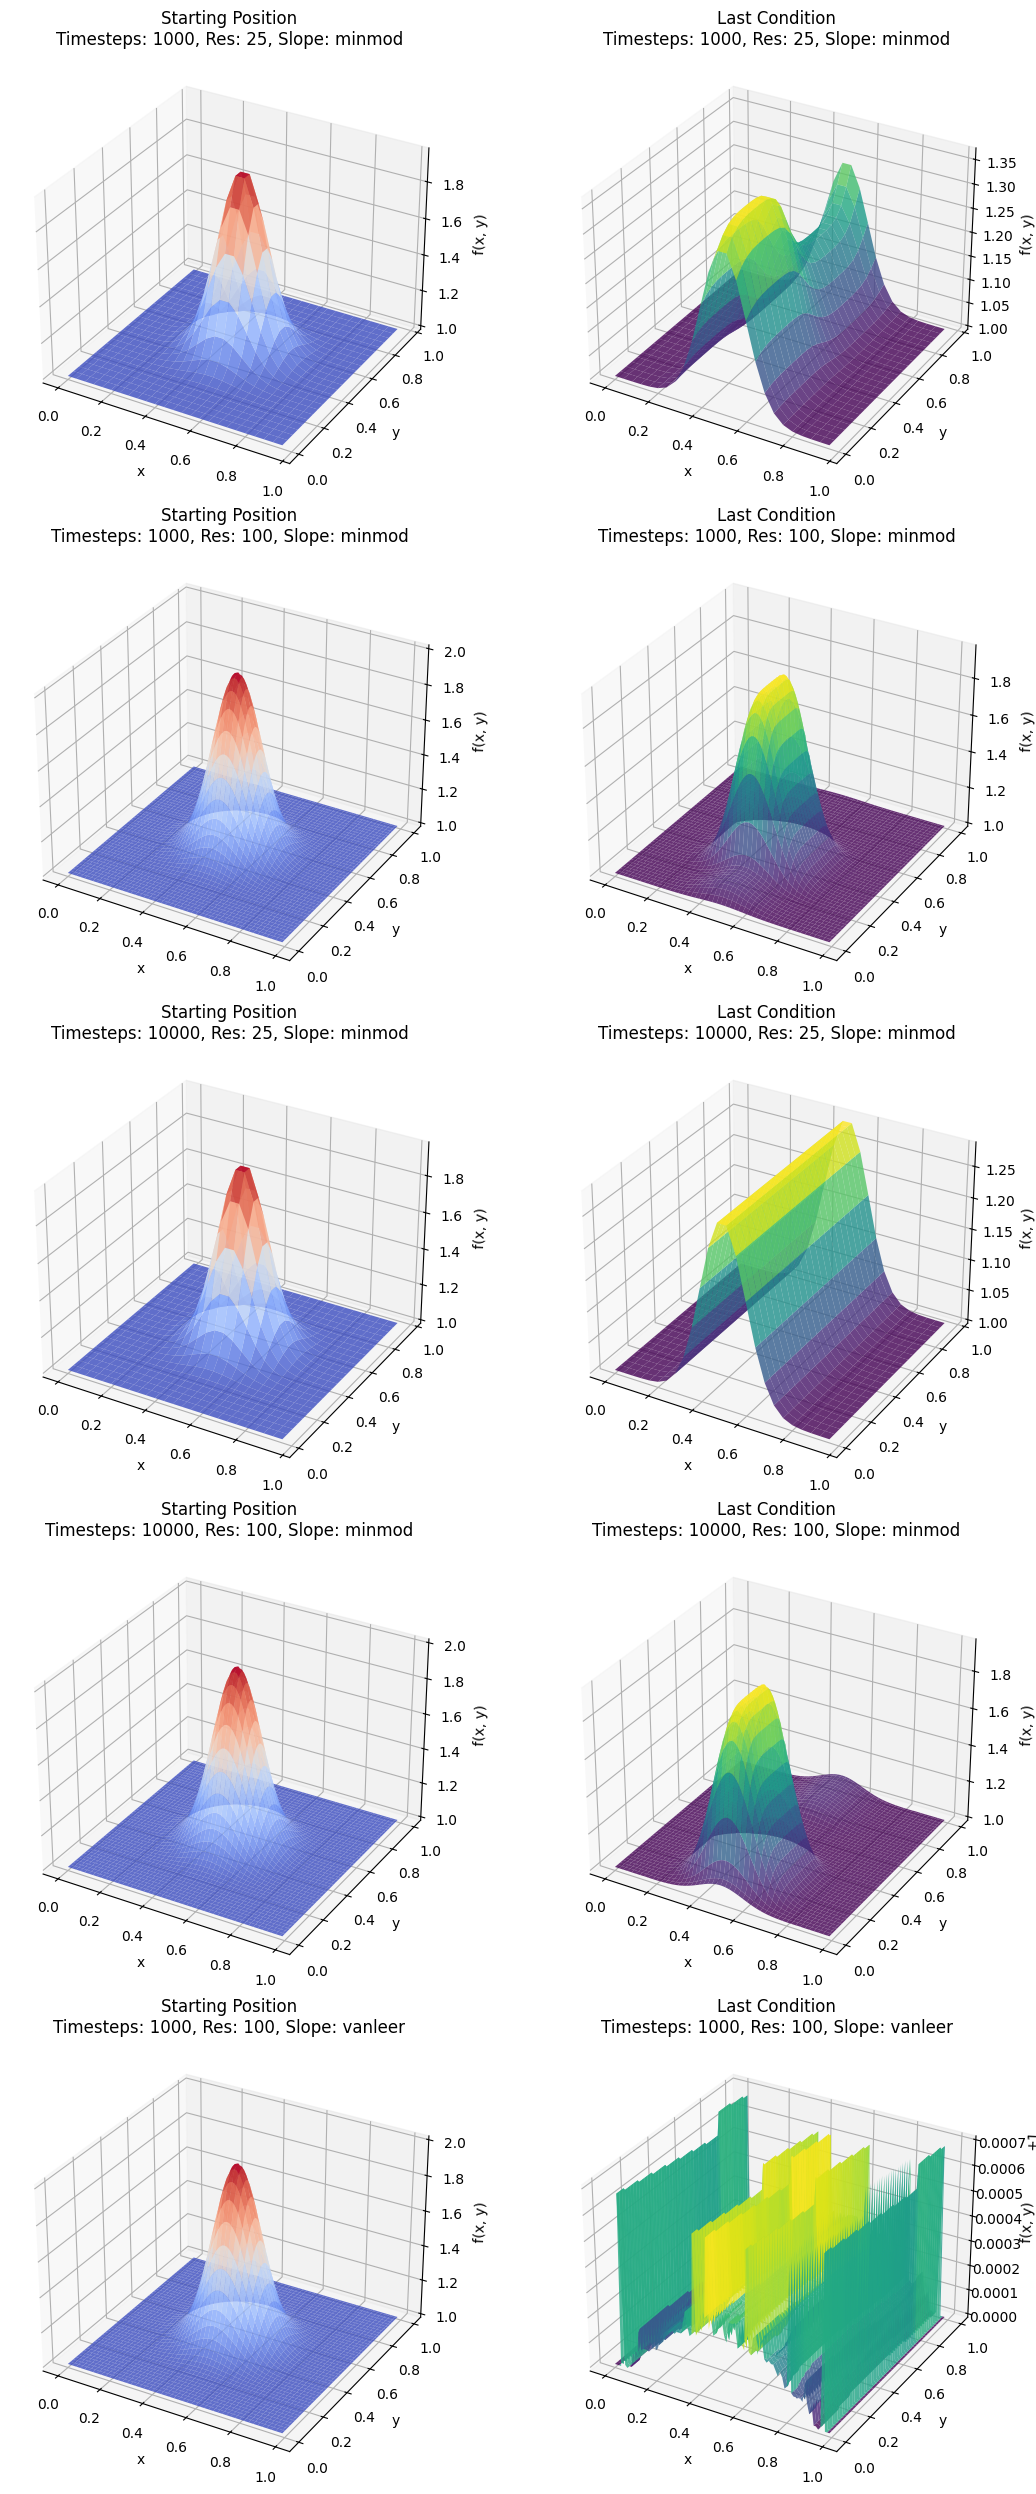

In [10]:
# Assuming data_results contains 2D data for plotting
num_plots = len(data_results)
fig, axs = plt.subplots(num_plots, 2, subplot_kw={"projection": "3d"}, figsize=(12, 5 * num_plots))

# If there's only one plot, axs will not be a 2D array, so we need to handle that case
if num_plots == 1:
    axs = np.array([axs])

# We will loop through the results and populate each subplot
for i, ((num_timesteps, resolution, slope_limiter), data) in enumerate(data_results.items()):
    x = data["x"].unique()
    y = data["y"].unique()
    X, Y = np.meshgrid(x, y)
    
    # Extract the first and last timestep
    first_timestep = data.iloc[:, 2].values.reshape(len(y), len(x))  # First timestep is the 3rd column (index 2)
    last_timestep = data.iloc[:, -1].values.reshape(len(y), len(x))  # Last timestep is the last column
    
    # Left column: Starting position (first timestep)
    ax_left = axs[i, 0]
    ax_left.plot_surface(X, Y, first_timestep, cmap=cm.coolwarm, alpha=0.8)
    ax_left.set_title(f"Starting Position\nTimesteps: {num_timesteps}, Res: {resolution}, Slope: {slope_limiter}")
    ax_left.set_xlabel("x")
    ax_left.set_ylabel("y")
    ax_left.set_zlabel("f(x, y)")
    
    # Right column: Last condition (last timestep)
    ax_right = axs[i, 1]
    ax_right.plot_surface(X, Y, last_timestep, cmap=cm.viridis, alpha=0.8)
    ax_right.set_title(f"Last Condition\nTimesteps: {num_timesteps}, Res: {resolution}, Slope: {slope_limiter}")
    ax_right.set_xlabel("x")
    ax_right.set_ylabel("y")
    ax_right.set_zlabel("f(x, y)")

# Adjust layout so subplots don't overlap
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

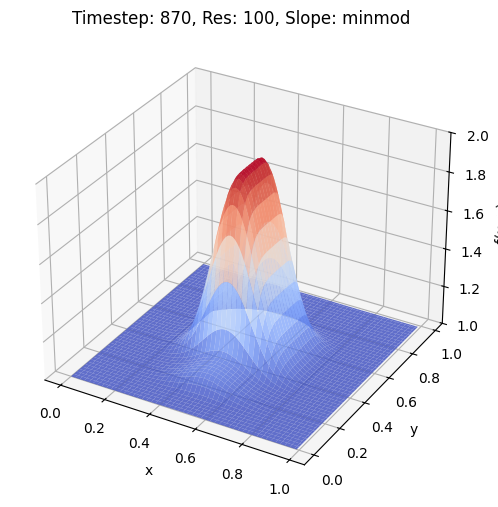

In [26]:
# Assuming data_results contains 2D data for plotting
# We will use the first entry in data_results for the animation
(num_timesteps, resolution, slope_limiter), data = next(iter(data_results.items()))

# Extract x, y coordinates and timesteps
x = data["x"].unique()
y = data["y"].unique()
X, Y = np.meshgrid(x, y)

# Extract all timesteps
timesteps = data.columns[2:]  # Skip "x" and "y" columns
Z = np.array([data[timestep].values.reshape(len(y), len(x)) for timestep in timesteps])

# Create a figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Function to update the plot for each frame of the animation
def update(frame):
    ax.clear()
    ax.plot_surface(X, Y, Z[frame], cmap=cm.coolwarm, alpha=0.8)
    ax.set_title(f"Timestep: {frame}, Res: {resolution}, Slope: {slope_limiter}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")
    ax.set_zlim(np.min(Z), np.max(Z))  # Fix z-axis limits for consistency

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(timesteps)/100, interval=100, repeat=False)

# Save the animation as a GIF or MP4 (optional)
ani.save("animation_2D_advection.webm", writer="ffmpeg", fps=10, codec="vp9")
# Display the animation
plt.show()